A notebook to verify we learn the correct priors when fitting only the priors

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.math.basic_functions import optimal_orthonormal_transform
from janelia_core.ml.utils import list_torch_devices

from probabilistic_model_synthesis.fa import FAMdl
from probabilistic_model_synthesis.fa import Fitter
from probabilistic_model_synthesis.fa import generate_simple_prior_collection
from probabilistic_model_synthesis.fa import generate_basic_posteriors
from probabilistic_model_synthesis.fa import VICollection
from probabilistic_model_synthesis.math import MeanFcnTransformer
from probabilistic_model_synthesis.math import StdFcnTransformer
from probabilistic_model_synthesis.visualization import plot_torch_dist


## Parameters go here

In [3]:
# Number of individuals we simulate observing data from 
n_individuals = 5

# Range of the number of variables we observe from each individual - the actual number of variables we observe from an
# individual will be pulled uniformly from this range (inclusive)
n_var_range = [1000, 1200]

# Range of the number of samples we observe from each individual - the actual number we observe from each individual
# will be unformly from this range (inclusive)
n_smps_range = [1000, 1500]

# Number of latent variables in the model
n_latent_vars = 2

# True if we should use GPUs for fitting if they are available
use_gpus = True

## Create the true prior distributions that relate parameters in the model to variable (e.g., neuron) properties

In [4]:
true_priors = generate_simple_prior_collection(n_prop_vars=2, n_latent_vars=n_latent_vars, 
                                               lm_mn_w_init_std=1.0, lm_std_w_init_std=1.0,
                                               mn_mn_w_init_std=1.0, mn_std_w_init_std=1.0,
                                               psi_conc_f_w_init_std=2.0, psi_rate_f_w_init_std=1.0, 
                                               psi_conc_bias_mn=10.0, psi_rate_bias_mn=3.0)

## Generate properties

In [5]:
ind_n_vars = np.random.randint(n_var_range[0], n_var_range[1]+1, n_individuals)
ind_n_smps = np.random.randint(n_smps_range[0], n_smps_range[1]+1, n_individuals)
ind_props = [torch.rand(size=[n_vars,2]) for n_vars in ind_n_vars]

## Generate true FA models

In [6]:
with torch.no_grad():
    ind_true_fa_mdls = [FAMdl(lm=true_priors.lm_prior.sample(props), mn=true_priors.mn_prior.sample(props).squeeze(), 
                           psi=(true_priors.psi_prior.sample(props).squeeze()))
                        for props in ind_props]

## Generate data from each model

In [7]:
with torch.no_grad():
    ind_data = [mdl.sample(n_smps) for n_smps, mdl in zip(ind_n_smps, ind_true_fa_mdls)]

## Fit new models together

In [41]:
#fit_priors = generate_simple_prior_collection(n_prop_vars=2, n_latent_vars=n_latent_vars)

fit_priors = generate_simple_prior_collection(n_prop_vars=2, n_latent_vars=n_latent_vars, 
                                               lm_mn_w_init_std=1.0, lm_std_w_init_std=1.0,
                                               mn_mn_w_init_std=1.0, mn_std_w_init_std=1.0,
                                               psi_conc_f_w_init_std=2.0, psi_rate_f_w_init_std=1.0, 
                                               psi_conc_bias_mn=10.0, psi_rate_bias_mn=3.0, 
                                               min_gaussian_std=.0001)

fit_posteriors = generate_basic_posteriors(n_obs_vars=ind_n_vars, n_smps=ind_n_smps, n_latent_vars=n_latent_vars)

fit_mdls = [FAMdl(lm=None, mn=None, psi=None) for i in range(n_individuals)]

vi_collections = [VICollection(data=data_i[1], props=props_i, mdl=mdl_i, posteriors=posteriors_i) 
                  for data_i, props_i,mdl_i, posteriors_i in zip(ind_data, ind_props, fit_mdls, fit_posteriors)]

In [42]:
for vi_coll in vi_collections:
    vi_coll.posteriors.lm_post = fit_priors.lm_prior
    vi_coll.posteriors.mn_post = fit_priors.mn_prior
    vi_coll.posteriors.psi_post = fit_priors.psi_prior

In [43]:
if use_gpus:
    devices, _ = list_torch_devices()
else:
    devices = [torch.device('cpu')]
    
fitter = Fitter(vi_collections=vi_collections, priors=fit_priors)

Found 2 GPUs


In [44]:
fitter.distribute(distribute_data=True, devices=devices)
log = fitter.fit(1000, milestones=[300, 500, 700, 1200], update_int=100, init_lr=.1, 
                       skip_lm_kl=True, skip_mn_kl=True, skip_psi_kl=True)
fitter.distribute(devices=[torch.device('cpu')])


=========== EPOCH 0 COMPLETE ===========
Obj: 4.10e+07
----------------------------------------
NELL: 7.67e+06, 7.07e+06, 9.55e+06, 8.08e+06, 8.67e+06
Latent KL: 1.06e+01, 2.27e+01, 1.25e+01, 9.35e+00, 2.83e+01
LM KL: 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
Mn KL: 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
Psi KL: 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
----------------------------------------
LR: 0.1
Elapsed time (secs): 0.08827900886535645
----------------------------------------
CPU cur memory used (GB): 4.07e+00
GPU_0 cur memory used (GB): 1.49e-02, max memory used (GB): 1.49e-02
GPU_1 cur memory used (GB): 8.62e-03, max memory used (GB): 8.62e-03

=========== EPOCH 100 COMPLETE ===========
Obj: 1.59e+07
----------------------------------------
NELL: 2.99e+06, 2.79e+06, 3.69e+06, 3.06e+06, 3.36e+06
Latent KL: 4.07e+03, 3.90e+03, 5.00e+03, 3.95e+03, 4.50e+03
LM KL: 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
Mn KL: 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00

## Examine logs of fitting performance

[True, True, True, True, True, True]


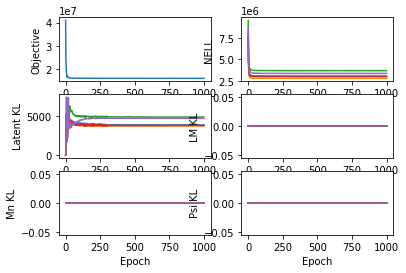

In [45]:
fitter.plot_log(log)

## Look at model fits

In [46]:
exam_mdl = 0

(1030, 2)


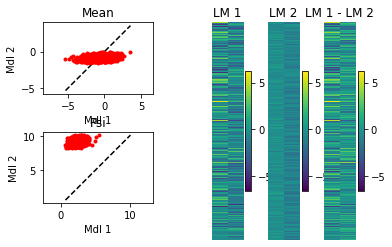

In [47]:
fit_lm = vi_collections[exam_mdl].posteriors.lm_post(ind_props[exam_mdl]).detach().squeeze()
fit_mn = vi_collections[exam_mdl].posteriors.mn_post(ind_props[exam_mdl]).detach().squeeze()
fit_psi = vi_collections[exam_mdl].posteriors.psi_post.mode(ind_props[exam_mdl]).detach().squeeze()

cmp_mdl = FAMdl(lm=fit_lm, mn=fit_mn, psi=fit_psi)
true_mdl = ind_true_fa_mdls[exam_mdl]

plt.figure()
true_mdl.compare_models(true_mdl, cmp_mdl)

### Visualize paraemters of the true prior distributions over the loading matrices

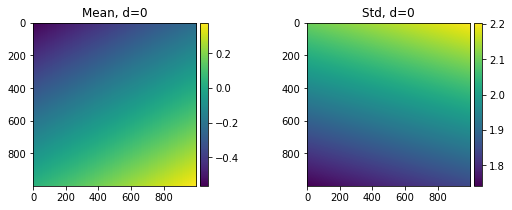

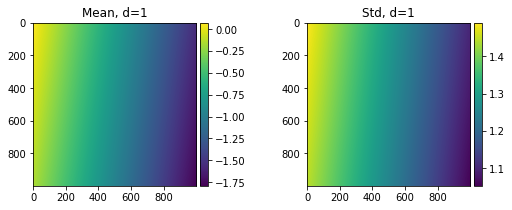

In [48]:
for d in range(n_latent_vars):
    plt.figure(figsize=(9,3))
    plot_torch_dist(mn_f=true_priors.lm_prior.mn_f, std_f=true_priors.lm_prior.std_f, vis_dim=d, 
                    extra_title_str = ', d=' + str(d))

### Visualize paraemters of the fit prior distributions over the loading matrices

In [49]:
rnd_vls = torch.rand(1000,2)
o = optimal_orthonormal_transform(true_priors.lm_prior(rnd_vls).detach().numpy(), 
                                  fit_priors.lm_prior(rnd_vls).detach().numpy())
fit_lm_mn_fcn = MeanFcnTransformer(o=o.transpose(), f=fit_priors.lm_prior.mn_f)
fit_lm_std_fcn = StdFcnTransformer(o=o.transpose(), f=fit_priors.lm_prior.std_f)

torch.Size([1000000, 2])
torch.Size([1000000, 2])


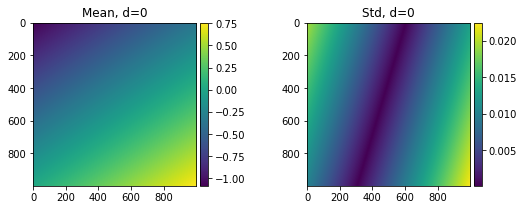

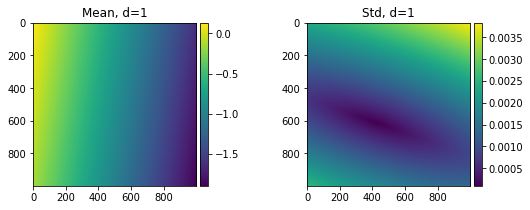

In [50]:
for d in range(n_latent_vars):
    plt.figure(figsize=(9,3))
    plot_torch_dist(mn_f=fit_lm_mn_fcn, std_f=fit_lm_std_fcn, vis_dim=d, 
                    extra_title_str = ', d=' + str(d))

### Visualize parameters of the true prior distribution over the means

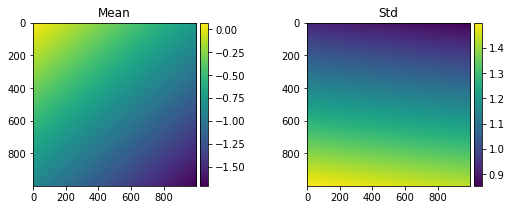

In [51]:
plt.figure(figsize=(9,3))
plot_torch_dist(mn_f=true_priors.mn_prior.mn_f, std_f=true_priors.mn_prior.std_f)

### Visualize parameters of the fit prior distribution over the means

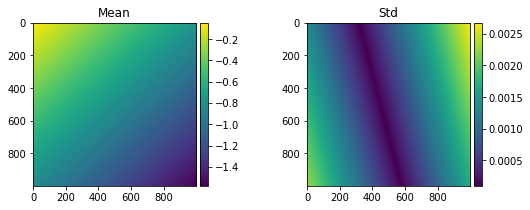

In [52]:
plt.figure(figsize=(9,3))
plot_torch_dist(mn_f=fit_priors.mn_prior.mn_f, std_f=fit_priors.mn_prior.std_f)

### Visualize parameters of the true prior distribution over private variances

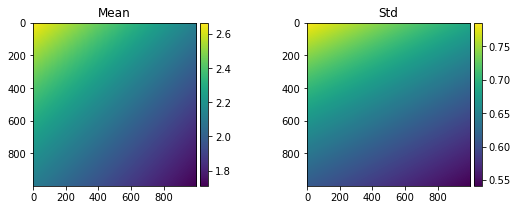

In [18]:
plt.figure(figsize=(9,3))
plot_torch_dist(mn_f=true_priors.psi_prior.forward, std_f=true_priors.psi_prior.std)

### Visualize parameters of the fit prior distribution over private variances

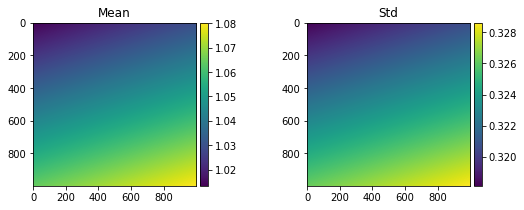

In [19]:
plt.figure(figsize=(9,3))
plot_torch_dist(mn_f=fit_priors.psi_prior.forward, std_f=fit_priors.psi_prior.std)

## Visualize latent estimates for an example model

In [ ]:
ex_s = 0

In [ ]:
# Learn transformation to put estimated latents into same space as true latents
with torch.no_grad():
    true_lm = ind_true_fa_mdls[ex_s].lm.numpy()
    est_lm = fit_posteriors[ex_s].lm_post(ind_props[ex_s]).numpy()
    o = optimal_orthonormal_transform(true_lm, est_lm)

In [ ]:
# Get estimated latents in the right space
est_latents = np.matmul(fit_posteriors[ex_s].latent_post.mns.detach().numpy(), o)

In [ ]:
# Visualize latents

In [ ]:
true_latents = ind_data[ex_s][0].numpy()

In [ ]:
plt.figure()
for l_i in range(n_latent_vars):
    ax = plt.subplot(n_latent_vars, 1, l_i+1)
    plt.plot(true_latents[:, l_i], 'bo')
    plt.plot(est_latents[:, l_i], 'r.')